# check dataloader

In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import sys

sys.path.append("/kaggle/src/data/")
from dss_dataloader import DSS3chDataset


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


In [4]:
train_event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")


In [5]:
train_event_df_null = train_event_df[train_event_df["step"].isnull()]
display(train_event_df_null.head())
isnull_series = train_event_df_null["series_id"].unique()


,series_id,night,event,step,timestamp
8,038441c925bb,5,onset,NaN,NaN
9,038441c925bb,5,wakeup,NaN,NaN
16,038441c925bb,9,onset,NaN,NaN
17,038441c925bb,9,wakeup,NaN,NaN
26,038441c925bb,14,onset,NaN,NaN


In [6]:
# series_df = pd.read_parquet("/kaggle/input/train_series_alldata_skffold.parquet")
series_df = pd.read_parquet("/kaggle/input/train_series_alldata_duplicate_fold.parquet")
print(series_df.columns)

series_df = series_df[series_df["series_id"].isin(isnull_series)].reset_index(drop=True)

key_df = series_df[["series_date_key", "series_date_key_str"]].drop_duplicates()
key_df["series_id"], key_df["date"] = (
    key_df["series_date_key_str"].str.split("_", 1).str
)
key_df = key_df.drop(columns=["series_date_key_str"], axis=1)


Index(['series_id', 'step', 'anglez', 'enmo', 'second', 'date', 'duplicate',
       'anglez_mean_36', 'anglez_std_36', 'anglez_mean_60', 'anglez_std_60',
       'event', 'event_onset', 'event_wakeup', 'series_date_key',
       'series_date_key_str', 'fold'],
      dtype='object')


In [7]:
event_df = pl.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
event_df = (
        event_df.pivot(
            index=["series_id", "night"], columns="event", values="step"
        )
        .drop_nulls()
        .to_pandas()
    )


6871
0


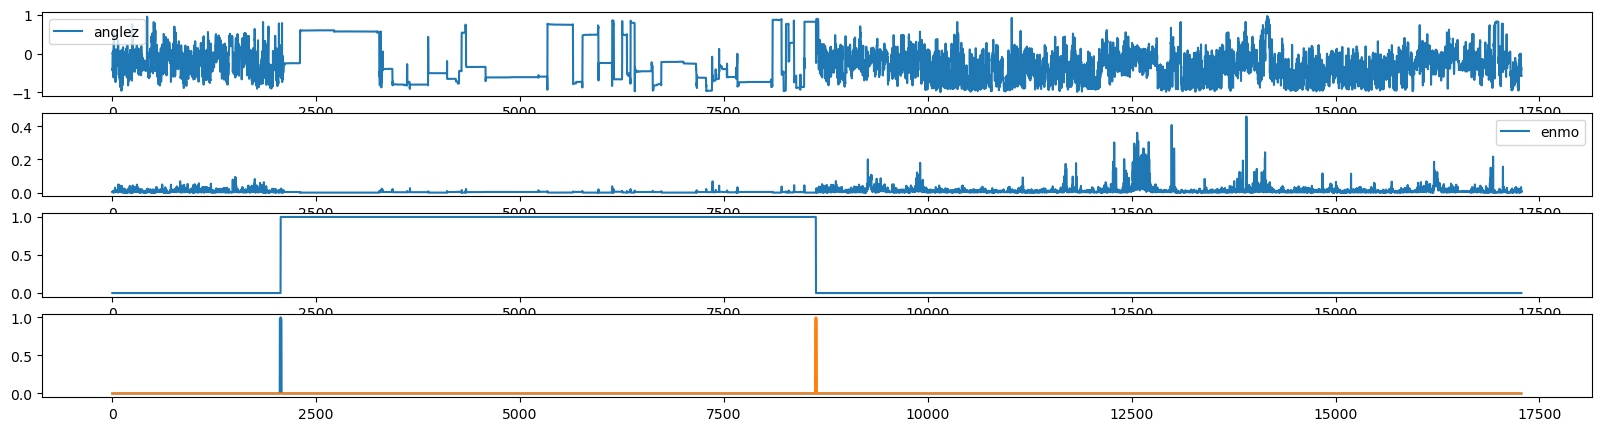

1


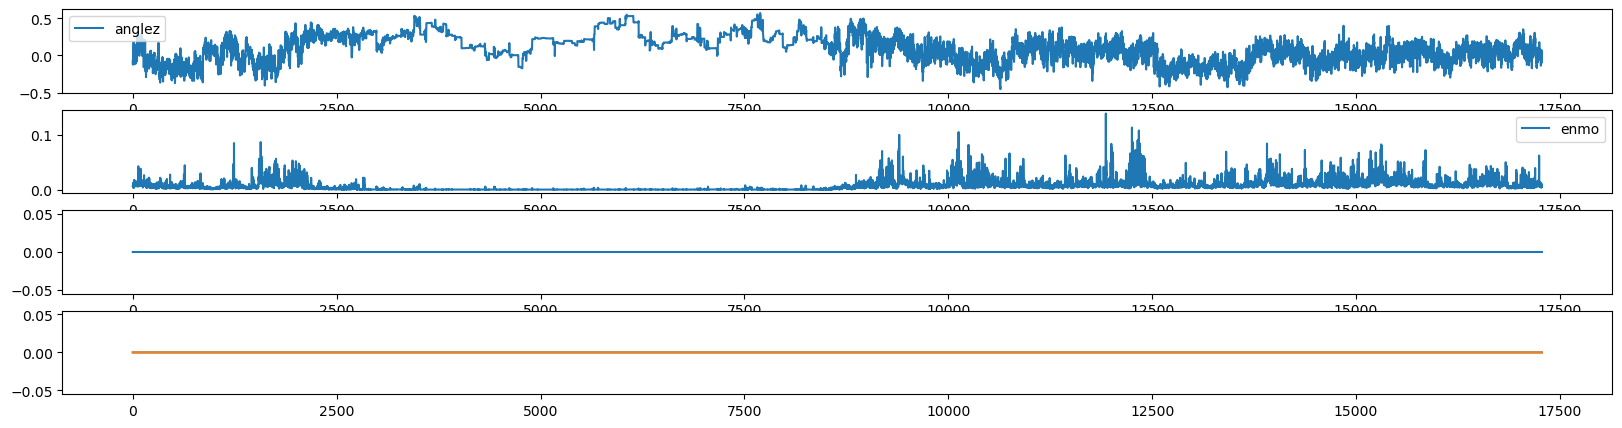

2


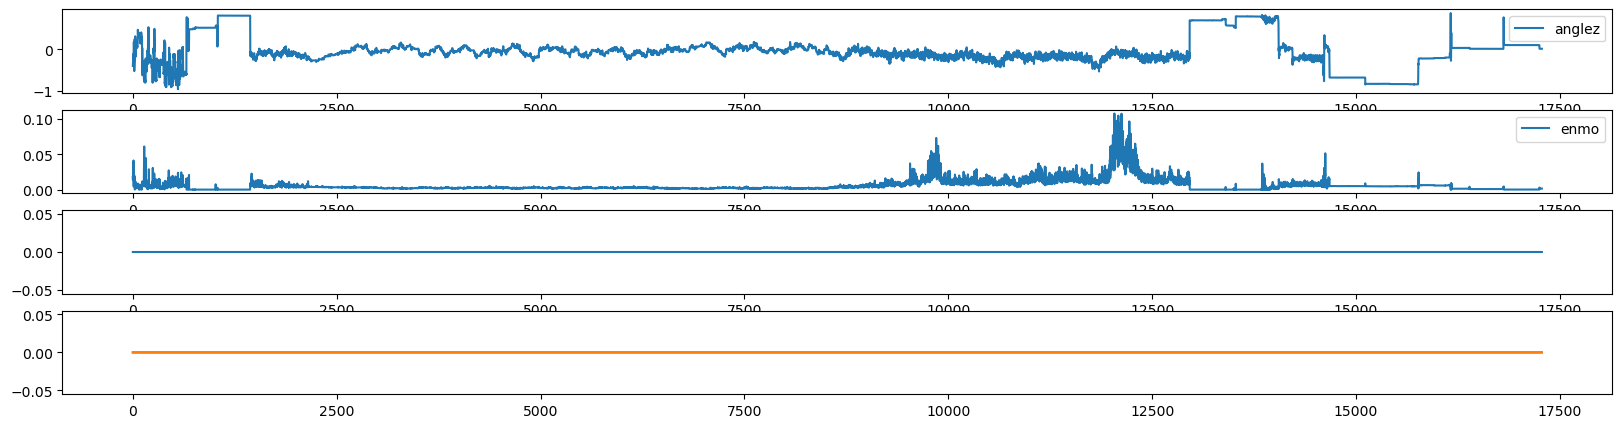

3


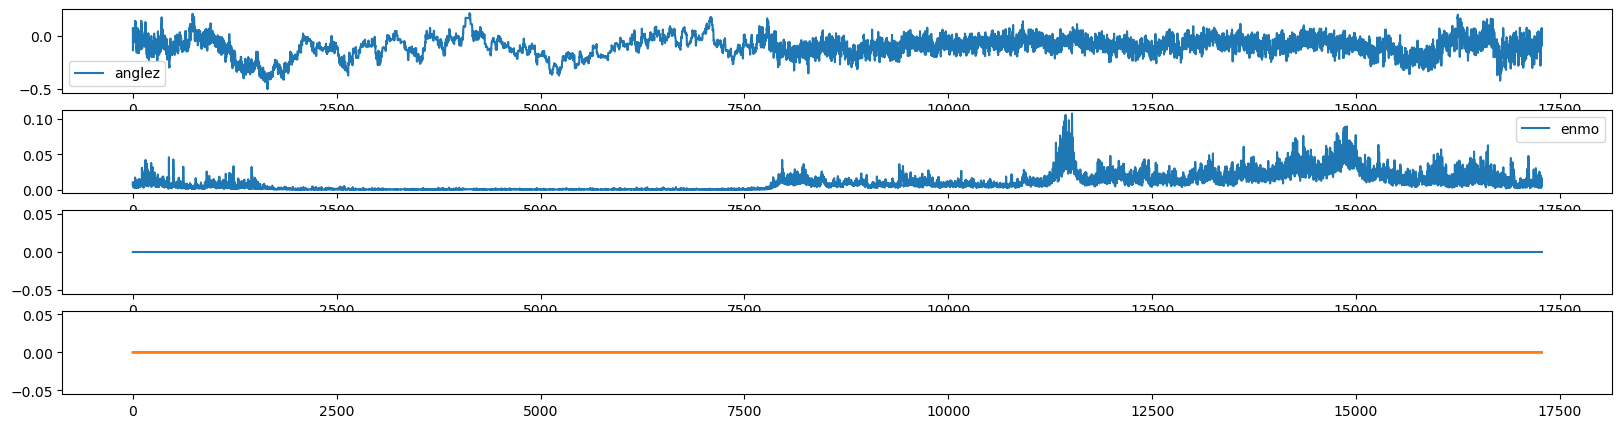

4


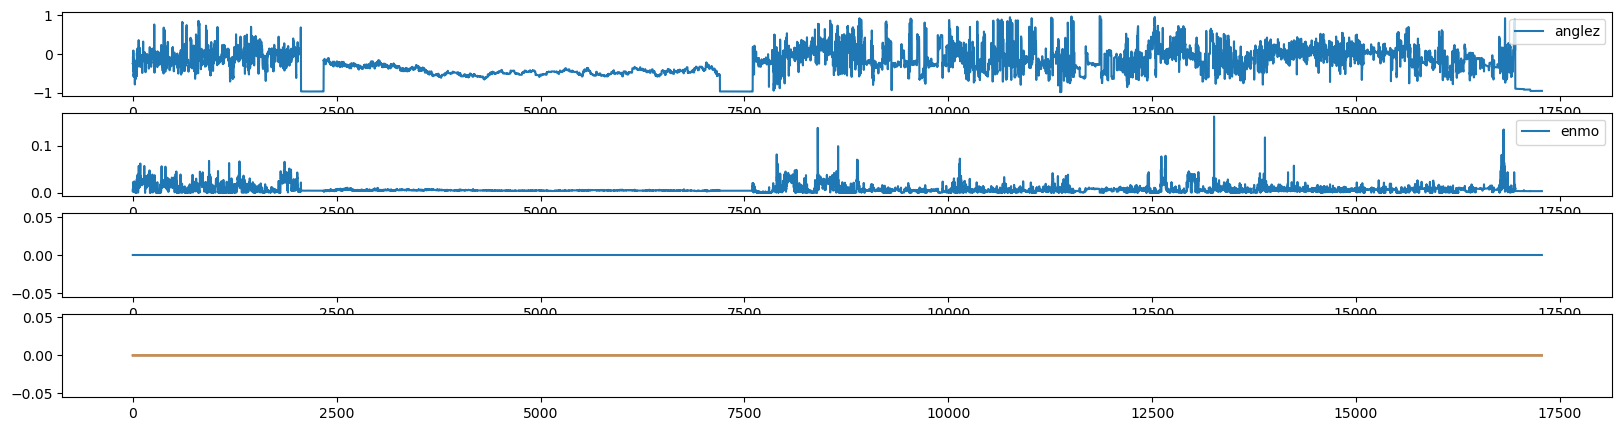

5


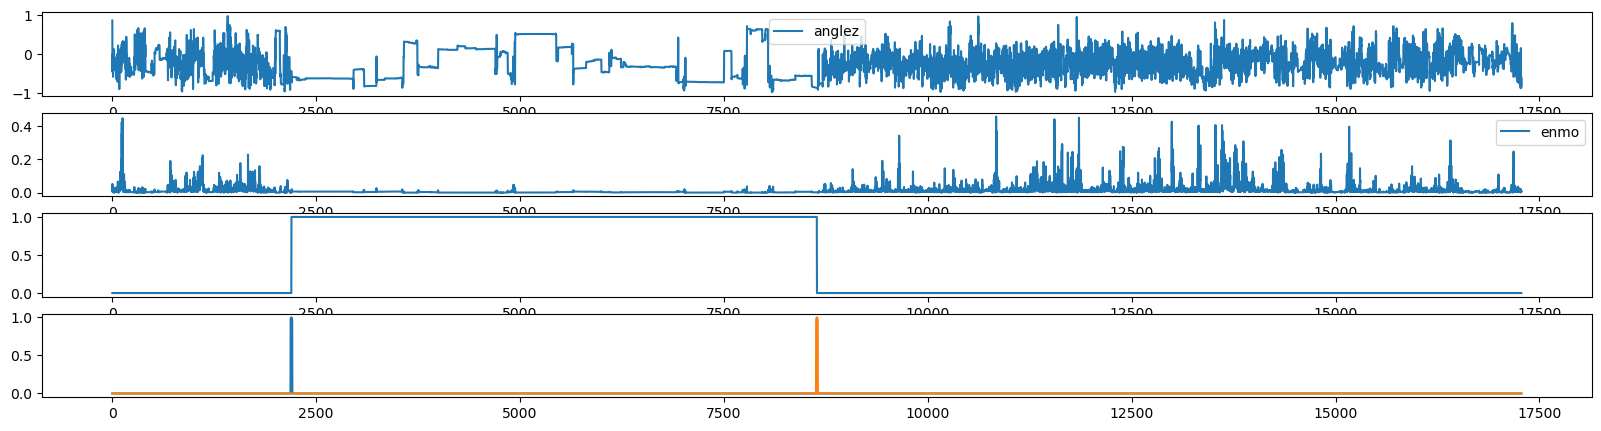

6


In [8]:
dataset = DSS3chDataset(key_df, series_df, event_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
print(len(dataset))
show_idx = 5
for idx, (input, target, input_info) in enumerate(dataloader):
    print(idx)
    # if idx < show_idx:
    #     continue
    if idx > show_idx:
        break
    plt.figure(figsize=(20, 5))
    plt.subplot(4, 1, 1)
    plt.plot(input[0, 0, :].numpy(), label="anglez")
    plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(input[0, 1, :].numpy(), label="enmo")
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.plot(target[0, 0, :].numpy(), label="sleep")
    plt.subplot(4, 1, 4)
    plt.plot(target[0, 1, :].numpy(), label="onset")
    plt.plot(target[0, 2, :].numpy(), label="wakeup")
    plt.show()
